# Convolutional Neural Networks (CNNs)

We want to process data (i.e. images) where the relative position of objects is relevant- we want the model to understand translational invariance, and also be able to discern features shared by neighbouring regions of the data (hard edges from dark/light contrast in the pixels, etc.)

If we are looking at an image of a plane in the sky, we are more interested in the local pixels that make up the plane rather than features or objects at a large distance- thus, we want pixels far from the plane to be "weighted" much less somehow than the pixels within the plane and up to its edges. One way of doing this would be to have a <b>weight matrix with many entries set to zero</b>. But there is a better approach.

# Convolution

Basically, we perform piecewise multiplication over the image tensor using a smaller tensor- or <b>kernel</b>. A typical size for a small kernel tensor would be $3 \times 3$. 

The operation of convolution essentially achieves what we would have by having weights equal to $0$ outside of the immediate region of the pixels.

The weights inside of the kernel are not known at the beginning, but instead are parameters to be optimized during training. 

In [18]:
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(123)

In [19]:
#Class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [20]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7'

#Initialise the training set
cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), #convert the images to tensors
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)) #normalise RGB values to have mean at 0 and with unit standard deviation
    ])
)

#Initialise the validation set
cifar10_val = datasets.CIFAR10(
    root=data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), #convert the images to tensors
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)) #normalise RGB values to have mean at 0 and with unit standard deviation
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
label_map = {0:0, 2:1} #map airplane to 0th index in cifar 2, map bird to index 1

#Extract the plane and bird images from cifar10 to create training and validation sets
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label == 0 or label == 2]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label == 0 or label == 2]

In [22]:
#Our new sequential model!

connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

#Combination of the logsoftmax output and the NLL loss function
loss_fn = nn.CrossEntropyLoss()

In [23]:
#Make a list of all of the model's modifiable parameters
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]
numel_list, sum(numel_list)

([3145728, 1024, 524288, 512, 65536, 128, 256, 2], 3737474)

In [24]:
conv = nn.Conv2d(3, 16, kernel_size=3)

#Weight matrix is 16x3x3x3- outputs a 2d image with 3 colour channels to a 16-dimensional vector
#This necessarily makes the bias vector have dimension 16
conv, conv.weight.shape, conv.bias.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

In [32]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) #add extra dimension that indicates BATCH number
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

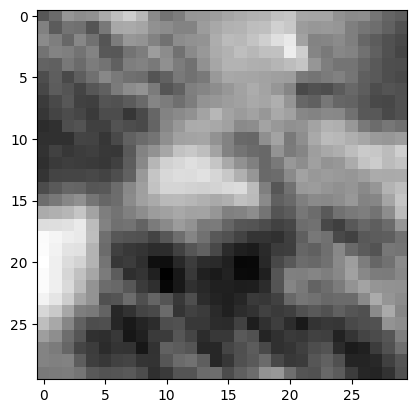

In [35]:
plt.imshow(output[0, 0].detach(), cmap='gray') #Select the image from batch 0, weight 0
plt.show() #produces 30x30 image

### Where did the other pixels go?
The kernel slides around the image from left to right, producing $$(\text{width}-\text{kernel size} + 1)$$ horizontal and vertical positions positions. Here, $32 - 3 + 1 = 30$, hence the resulting $30 \times 30$ dimensions.

We can add <b>padding</b> in order to introduce fictitious $0$ pixels around the border of the image in order to preserve the original dimensions.

In [37]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #Now the dimensions should match, as we've added a border of 0 pixels around the edge of the img matrix.

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [45]:
#Set the initial kernel parameters by hand 

#With 0 bias, and with the weights all set to 1/9, we expect the convolution to simply blur the image.
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

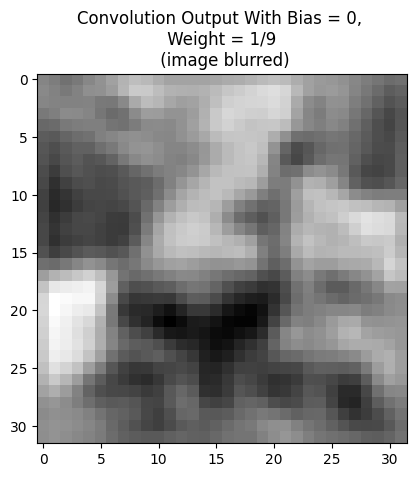

In [44]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title('Convolution Output With Bias = 0, \n Weight = 1/9 \n (image blurred)')
plt.show()

### Edge-Detection Kernel
We now use a kernel of the following form:

$$ \begin{bmatrix}
-1.0 & 0.0 & 1.0 \\
-1.0 & 0.0 & 1.0 \\
-1.0 & 0.0 & 1.0 
\end{bmatrix}  $$

which will return a <b>feature map</b> with large values when neighbouring pixels exhibit high contrast in their intensity (i.e. are at the edges of the image).

In [48]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) #Three input channels, RGB, and one output (gray value)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0], 
                                   [-1.0, 0, 1.0], 
                                   [-1.0, 0, 1.0]])
    conv.bias.zero_()

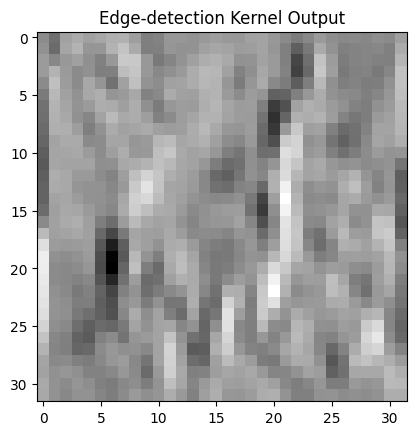

In [50]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0,0].detach(), cmap='gray')
plt.title('Edge-detection Kernel Output')
plt.show()